Aleksandra Bednarczuk

# Predictors of elderly citizens willingness to stay in the neighbourhood
# Logistic regression

Original dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from scipy import stats

In [3]:
data = pd.read_pickle("survey_transformed.pkl")

In [4]:
data.head()

,ANY,NOM_DISTRICTE,Would_not_stay_in_the_neighborhood,Gender,Time_living_in_barri,Barri_evolution,Barri_satisfaction_of_living,Barri_comparison,GARBAGE COLLECTION,STREETS CLEANING,...,House_size,Monthly_family_income,Social_class,Living_alone,BCN_evolution,BCN_satisfaction_of_living,BCN_transport,BCN_over_barri_evolution,BCN_over_barri_satisfaction_of_living,BCN_over_barri_transport
0,2007,CIUTAT VELLA,0.0,0,I HAVE ALWAYS LIVED IN THE CITY,IT HAS IMPROVED,SATISFIED,"NEITHER THE BEST, NOR THE WORST",GOOD,BAD,...,51-100 M2,1001-2000 EUROS,MIDDLE-LOW,0,IT HAS IMPROVED,SATISFIED,GOOD,0,0,0
5,2007,CIUTAT VELLA,0.0,1,MORE THAN 10 YEARS,IT HAS IMPROVED,SATISFIED,"NEITHER THE BEST, NOR THE WORST",GOOD,GOOD,...,51-100 M2,< 1000 EUROS,MIDDLE-LOW,0,IT HAS IMPROVED,SATISFIED,GOOD,0,0,0
7,2007,CIUTAT VELLA,1.0,0,I HAVE ALWAYS LIVED IN THE CITY,IT IS WORSE,I DON'T KNOW / NO ANSWER,"NEITHER THE BEST, NOR THE WORST",GOOD,GOOD,...,< 50 M2,1001-2000 EUROS,MIDDLE-LOW,0,IT HAS IMPROVED,NOT SATISFIED,GOOD,1,0,0
9,2007,CIUTAT VELLA,0.0,1,MORE THAN 10 YEARS,IT IS WORSE,SATISFIED,"NEITHER THE BEST, NOR THE WORST",GOOD,BAD,...,101-150 M2,< 1000 EUROS,MIDDLE-LOW,0,IT HAS IMPROVED,SATISFIED,GOOD,1,0,1
12,2007,CIUTAT VELLA,0.0,1,I HAVE ALWAYS LIVED IN THE CITY,IT HAS IMPROVED,SATISFIED,ONE OF THE BEST,GOOD,BAD,...,51-100 M2,< 1000 EUROS,MIDDLE-LOW,1,IT HAS IMPROVED,SATISFIED,GOOD,0,0,0


In [5]:
data.shape

(10915, 32)

In [6]:
# Dataset is imbalanced
data.groupby(['Would_not_stay_in_the_neighborhood']).size()

Would_not_stay_in_the_neighborhood
0.0    9697
1.0    1218
dtype: int64

In [7]:
data.columns.tolist()

['ANY',
 'NOM_DISTRICTE',
 'Would_not_stay_in_the_neighborhood',
 'Gender',
 'Time_living_in_barri',
 'Barri_evolution',
 'Barri_satisfaction_of_living',
 'Barri_comparison',
 'GARBAGE COLLECTION',
 'STREETS CLEANING',
 'GREEN AREAS',
 'PUBLIC LIGHTING',
 'URBANISM',
 'ASPHALT AND STREET CONSERVATION',
 'FACADES AND BUILDING CONSERVATION',
 'CIRCULATION',
 'BUS',
 'CITIZEN SECURITY IN THE CITY AS A WHOLE',
 'CITIZEN SECURITY IN THE NEIGHBORHOOD',
 'MUNICIPAL MARKETS',
 'Barri_transport',
 'Owns_a_car',
 'House_size',
 'Monthly_family_income',
 'Social_class',
 'Living_alone',
 'BCN_evolution',
 'BCN_satisfaction_of_living',
 'BCN_transport',
 'BCN_over_barri_evolution',
 'BCN_over_barri_satisfaction_of_living',
 'BCN_over_barri_transport']

In [8]:
x_var = data.columns.tolist()

In [9]:
for i in ['ANY', 'Would_not_stay_in_the_neighborhood',
          'BCN_evolution', 'BCN_satisfaction_of_living', 'BCN_transport']:
    x_var.remove(i)

In [10]:
x = data[x_var]

In [11]:
y = data['Would_not_stay_in_the_neighborhood']

In [12]:
x = pd.get_dummies(x)

In [13]:
for i in x.columns.tolist():
    if i[-5:] == "_GOOD":
        del x[i]

In [14]:
for i in [#'Gender', 'Owns_a_car', 'Living_alone',
    #'BCN_over_barri_evolution', 'BCN_over_barri_satisfaction_of_living', 'BCN_over_barri_transport',
    
    #'NOM_DISTRICTE_CIUTAT VELLA', 'NOM_DISTRICTE_EIXAMPLE', 'NOM_DISTRICTE_GRÀCIA', 'NOM_DISTRICTE_HORTA - GUINARDÓ',
    #'NOM_DISTRICTE_LES CORTS', 'NOM_DISTRICTE_NOU BARRIS', 'NOM_DISTRICTE_SANT ANDREU', 'NOM_DISTRICTE_SANT MARTÍ',
    #'NOM_DISTRICTE_SANTS - MONTJUÏC',
    'NOM_DISTRICTE_SARRIÀ - SANT GERVASI',
    
    #'Time_living_in_barri_I HAVE ALWAYS LIVED IN THE CITY',
    'Time_living_in_barri_LESS THAN 10 YEARS',
    #'Time_living_in_barri_MORE THAN 10 YEARS',
    
    #"Barri_evolution_I DON'T KNOW / NO ANSWER",
    'Barri_evolution_IT HAS IMPROVED',
    #'Barri_evolution_IT IS THE SAME',
    #'Barri_evolution_IT IS WORSE',
    
    #"Barri_satisfaction_of_living_I DON'T KNOW / NO ANSWER",
    #'Barri_satisfaction_of_living_NOT SATISFIED',
    'Barri_satisfaction_of_living_SATISFIED',
    
    #"Barri_comparison_I DON'T KNOW / NO ANSWER",
    #'Barri_comparison_NEITHER THE BEST, NOR THE WORST',
    'Barri_comparison_ONE OF THE BEST',
    #'Barri_comparison_ONE OF THE WORST',
    
    #'House_size_101-150 M2', 'House_size_51-100 M2',
    'House_size_< 50 M2',
    #'House_size_> 150 M2',
    
    #'Monthly_family_income_1001-2000 EUROS', 'Monthly_family_income_2001-3000 EUROS',
    'Monthly_family_income_< 1000 EUROS',
    #'Monthly_family_income_> 3000 EUROS',
    
    #'Social_class_HIGH','Social_class_MIDDLE-HIGH','Social_class_MIDDLE-LOW','Social_class_MIDDLE-MIDDLE',
    'Social_class_LOW']:
    del x[i]

In [15]:
x = sm.add_constant(x)

In [16]:
resampling = SMOTETomek(random_state=0)
 
columns = x.columns
x_resampled, y_resampled = resampling.fit_sample(x.astype(int), y)
x_resampled = pd.DataFrame(data=x_resampled, columns=columns )
y_resampled= pd.DataFrame(data=y_resampled, columns=['Would_not_stay_in_the_neighborhood'])

print("length of oversampled data is ",len(x_resampled))
print("Number of people who would not stay in the neighborhood in resampled data",
      len(y_resampled[y_resampled['Would_not_stay_in_the_neighborhood']==1]))
print("Number of people who would stay in the neighborhood in resampled data",
      len(y_resampled[y_resampled['Would_not_stay_in_the_neighborhood']==0]))
print("Proportion of 'Would_not_stay_in_the_neighborhood' in resampled data is ",
      len(y_resampled[y_resampled['Would_not_stay_in_the_neighborhood']==1])/len(x_resampled))
print("Proportion of subscription data in resampled data is ",
      len(y_resampled[y_resampled['Would_not_stay_in_the_neighborhood']==0])/len(x_resampled))

length of oversampled data is  19256
Number of people who would not stay in the neighborhood in resampled data 9628
Number of people who would stay in the neighborhood in resampled data 9628
Proportion of 'Would_not_stay_in_the_neighborhood' in resampled data is  0.5
Proportion of subscription data in resampled data is  0.5


In [17]:
x_resampled

,const,Gender,Owns_a_car,Living_alone,BCN_over_barri_evolution,BCN_over_barri_satisfaction_of_living,BCN_over_barri_transport,NOM_DISTRICTE_CIUTAT VELLA,NOM_DISTRICTE_EIXAMPLE,NOM_DISTRICTE_GRÀCIA,...,House_size_101-150 M2,House_size_51-100 M2,House_size_> 150 M2,Monthly_family_income_1001-2000 EUROS,Monthly_family_income_2001-3000 EUROS,Monthly_family_income_> 3000 EUROS,Social_class_HIGH,Social_class_MIDDLE-HIGH,Social_class_MIDDLE-LOW,Social_class_MIDDLE-MIDDLE
0,1,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
1,1,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,1,0,1,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1,1,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19251,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
19252,1,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
19253,1,1,0,1,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
19254,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
y_resampled['Would_not_stay_in_the_neighborhood'].unique()

array([0., 1.])

In [19]:
logit_model = sm.Logit(y_resampled,x_resampled)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.443339
         Iterations 7
                                                 Results: Logit
Model:                        Logit                                        Pseudo R-squared:           0.360     
Dependent Variable:           Would_not_stay_in_the_neighborhood           AIC:                        17199.8723
Date:                         2021-04-25 17:02                             BIC:                        17695.4037
No. Observations:             19256                                        Log-Likelihood:             -8536.9   
Df Model:                     62                                           LL-Null:                    -13347.   
Df Residuals:                 19193                                        LLR p-value:                0.0000    
Converged:                    1.0000                                       Scale:                      1.0000    
No. Iterations:               7.0000

In [20]:
result.pvalues.sort_values(ascending=False)

GREEN AREAS_BAD                                                   9.266448e-01
BCN_over_barri_satisfaction_of_living                             8.650821e-01
CITIZEN SECURITY IN THE NEIGHBORHOOD_I DON'T KNOW / NO ANSWER     8.432497e-01
Barri_comparison_I DON'T KNOW / NO ANSWER                         4.590534e-01
URBANISM_BAD                                                      4.086982e-01
                                                                     ...      
NOM_DISTRICTE_SANT ANDREU                                        3.225901e-164
NOM_DISTRICTE_NOU BARRIS                                         1.173658e-195
NOM_DISTRICTE_EIXAMPLE                                           6.053896e-216
NOM_DISTRICTE_SANT MARTÍ                                         1.895384e-234
const                                                             0.000000e+00
Length: 63, dtype: float64

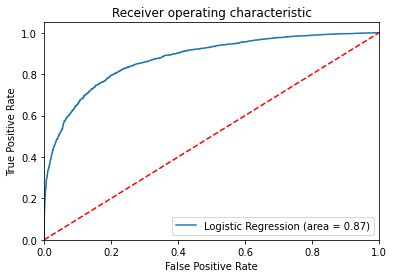

In [21]:
logit_roc_auc = roc_auc_score(y_resampled, result.predict(x_resampled))
fpr, tpr, thresholds = roc_curve(y_resampled, result.predict(x_resampled))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [ ]:
# NIE POPRAWIŁAM PONIŻSZEGO FEATURE SELECTION

In [23]:
for i in ['BCN_over_barri_satisfaction_of_living',
         'PUBLIC LIGHTING_BAD', "PUBLIC LIGHTING_I DON'T KNOW / NO ANSWER"]:
    del x_resampled[i]

In [24]:
logit_model = sm.Logit(y_resampled,x_resampled)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.443444
         Iterations 7
                                                 Results: Logit
Model:                        Logit                                        Pseudo R-squared:           0.360     
Dependent Variable:           Would_not_stay_in_the_neighborhood           AIC:                        17197.9041
Date:                         2021-04-25 17:15                             BIC:                        17669.8388
No. Observations:             19256                                        Log-Likelihood:             -8539.0   
Df Model:                     59                                           LL-Null:                    -13347.   
Df Residuals:                 19196                                        LLR p-value:                0.0000    
Converged:                    1.0000                                       Scale:                      1.0000    
No. Iterations:               7.0000

In [ ]:
result.pvalues.sort_values(ascending=False)

In [ ]:
logit_roc_auc = roc_auc_score(y_resampled, result.predict(x_resampled))
fpr, tpr, thresholds = roc_curve(y_resampled, result.predict(x_resampled))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [ ]:
for i in ['BCN_over_barri_future', 'FACADES AND BUILDING CONSERVATION_BAD']:
    del x_resampled[i]

In [ ]:
logit_model = sm.Logit(y_resampled,x_resampled)
result=logit_model.fit()
print(result.summary2())

In [ ]:
result.pvalues.sort_values(ascending=False)

In [ ]:
logit_roc_auc = roc_auc_score(y_resampled, result.predict(x_resampled))
fpr, tpr, thresholds = roc_curve(y_resampled, result.predict(x_resampled))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [22]:
print(result.get_margeff().summary())

                Logit Marginal Effects               
Dep. Variable:     Would_not_stay_in_the_neighborhood
Method:                                          dydx
At:                                           overall
                                                                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Gender                                                              -0.0476      0.006     -8.001      0.000      -0.059      -0.036
Owns_a_car                                                          -0.0344      0.006     -5.307      0.000      -0.047      -0.022
Living_alone                                                        -0.1153      0.007    -16.546      0.000      -0.129      -0.102
BCN_over_barri_evolution                                            -0.1263      0.011    -11.462      0.000      -0.14

In [ ]:
result.pred_table()

In [ ]:
logit_roc_auc = roc_auc_score(y_resampled, result.predict(x_resampled))
fpr, tpr, thresholds = roc_curve(y_resampled, result.predict(x_resampled))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [ ]:
np.exp(result.params)